In [1]:
clean_up = True
%run stdPackages.ipynb
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])

### 1. Settings

In [2]:
name = 'A' # name of model
module = name+'HH' # name of module
db_IO = GpyDB(f"{d['data']}\\IO_{name}") # load IO database named IO_name
db_IO0 = db_IO.copy() # we are going to adjust data along the way; this keeps a copy of the original data
with open(f"{d['data']}\\glob_{name}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)
Tree = nestingTree.aggTree_from_data(f"{d['data']}\\A_HouseholdNests.xlsx", read_trees = {'consumption': {'name': module+'_Nest', 'f':'CES'}}, name = module)() # load nesting structure 
otherData = read.SeriesDB_from_wb(f"{d['data']}\\A_HouseholdNests.xlsx", {'variables': ['labor'], 'maps': ['maps']})
robust.robust_merge_dbs(Tree.db, otherData, priority='second')

### 2. Initialize module

*Initialize module without any savings first (static method):*

In [3]:
H = CGE_Households.SimpleRamsey(tree = Tree, glob = glob, kwargs = {'L2C': otherData['L2C'].vals, 'svngs': db_IO.get('svngs')}) # init module
aggregateDB.subset_db(db_IO, H.get('s')) # Keep data on relevant sectors
aggregateDB.subset_db(db_IO, H.get('n')) # Keep data on relevant goods
robust.robust_merge_dbs(H.s.db, db_IO, priority = 'second') # Merge IO data into the database of the module; if a symbol is in both, prioritize records from the second database

*Value shares for nesting part:*

In [4]:
v = valueShares.SimpleRamsey(Tree, db_IO.copy())
v.compile() # set up model structure, and make sure to initialize symbols if they are not yet defined in the database 
v.write(); # write GAMS code used for the model
m = v.run(exportTo = d['work'],ws=ws) # solve the "model".

Use value shares to initialize variables:
* Outputs and inputs are provided by IO data.
* For intermediate goods, assume a price of 1 (default option in the class, so we don't have to do anything) and set value share = quantity.
* Set share parameters to the ones identified by value share system.

In [5]:
gpyDB.GpyDBs_AOM_Second(H.s.db, gpy(adj.rc_pd(m.out_db.get('vD'), H.get('int')).rename('qD'))) # set intermediate goods levels
gpyDB.GpyDBs_AOM_Second(H.s.db, gpy(m.out_db.get('mu').xs(H.get('t0')[0]).rename('mu'))) # set share parameters

Fit lump sum taxation to total tax revenue:

In [6]:
H.s.db['tauLump'] = db_IO.get('TotalTax').rename('tauLump')
# H.s.db['frisch'] = H.get('frisch') * 0 # Fix labor supply

Use sneaky calibration method to solve and calibrate:

In [7]:
H.compile(initDB=True)
H.write();
mCalib, cp = H.sneakyCalib(db_IO, ws = ws, loop_kwargs = {'n': 25}, **{'cns': 'CONOPT4'})

Let's e.g. have a look at how assets evolve:

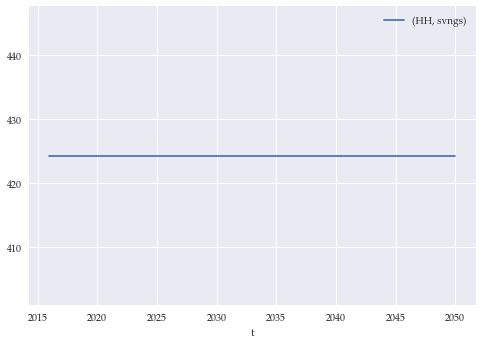

In [8]:
adj.rc_pd(mCalib.out_db.get('vD'), H.get('svngs')).unstack('s').unstack('n').plot(subplots=True, backend="matplotlib");

### 5. Export 

*Use data from the calibration step in the main database. The ```sneakyCalib``` method defines some new, auxiliary symbols - these are not used.*

In [9]:
[gpyDB.GpyDBs_AOM_Second(H.s.db, mCalib.out_db[k]) for k in H.s.db.symbols];
H.s.setstate('B')

Export:

In [10]:
with open(os.path.join(d['data'], H.name), "wb") as file:
    pickle.dump(H,file)